In [95]:
import numpy as np
import mujoco
import mediapy as media

from vis_util import Joint, open_files
np_data = open_files("aist/keypoints3d/gHO_sBM_cAll_d19_mHO2_ch07.pkl")
f=200

(480, 17, 3)
(480, 17, 3)


In [96]:
xml = './low_cost_robot/scene.xml'
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)

model.vis.global_.offheight = 720
model.vis.global_.offwidth = 1080

renderer = mujoco.Renderer(model, height=720, width=1080)

In [97]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 0.6


In [98]:
ranges = [
    [np.pi/2, -np.pi/2],  # Column 1 range\n",
    # TODO 이거 너무 range가 적은 것 같은데?
    [np.pi/8, -np.pi/8],  # Column 2 range\n",
    # [np.pi/2, np.pi/4],  # Column 3 range\n",
    [np.pi/2, 0],  # Column 3 range\n",

    [np.pi/2, -np.pi/2],  # Column 4 range\n",
    [np.pi/2, -np.pi/2],  # Column 5 range\n",
]

def denormalize(idx, point):
    point = np.clip(point, 0, 1)
    if idx == 5:
        return 0
    return ranges[idx][0] * point + ranges[idx][1] * (1 - point)

initial point,after point

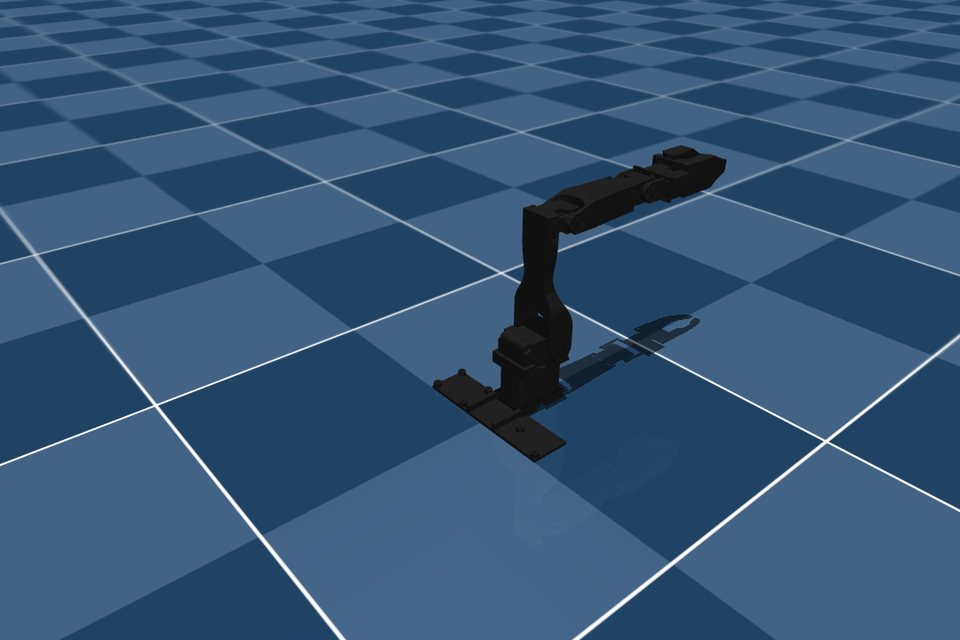
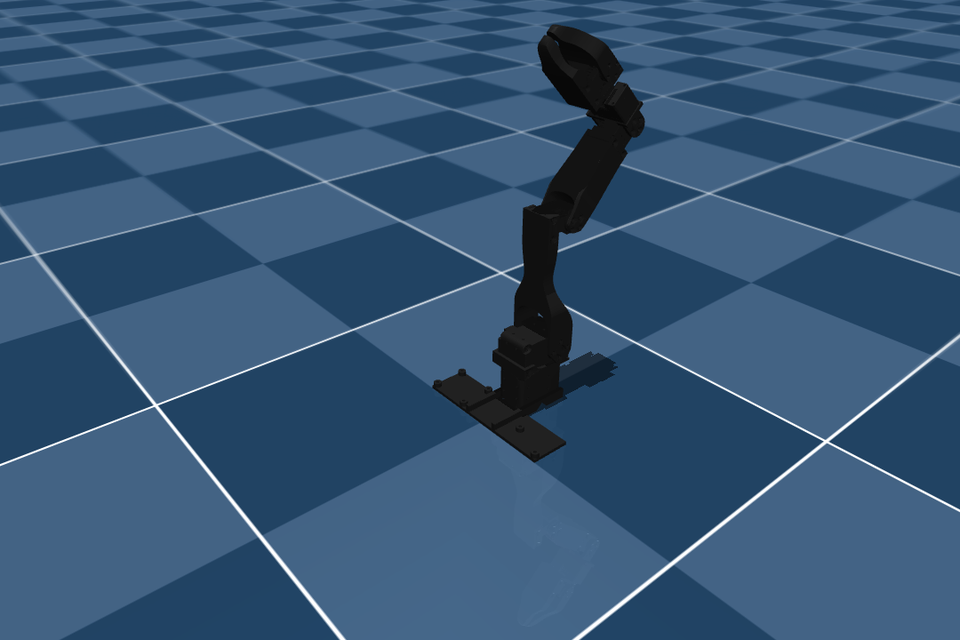

In [102]:
qinit = data.qpos.copy()
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
init_plot = renderer.render()


# init_point = data.body(jname).xpos.copy()
normalized_qpos = [0.5, 0.5, 0.5, 1, 0, 0]
data.qpos = np.array([denormalize(idx, p) for idx, p in enumerate(normalized_qpos)])
qpos0 = data.qpos.copy()
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
after_plot = renderer.render()

images = {
    "initial point": init_plot,
    "after point": after_plot,
}
media.show_images(images=images, height=640)

In [100]:
np_data.shape

(480, 17, 3)

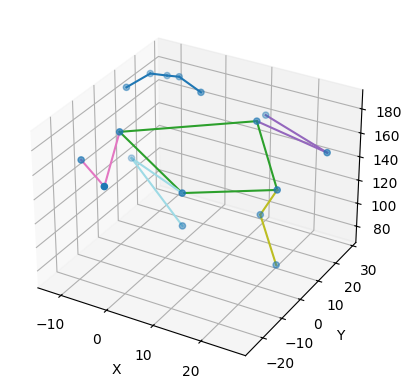

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
from vis_util import connections, connection_info, set_part_color

kpts_3d = np_data

# 특정 프레임 선택 (예: 첫 번째 프레임)
frame_kpts = kpts_3d[f]  # shape: (17, 3)

# x, y, z 좌표 분리
x = frame_kpts[:, 0]
y = frame_kpts[:, 1]
z = frame_kpts[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 점 플롯
ax.scatter(x, y, z)

cmap = colormaps["tab20"].resampled(len(connection_info))
for i, (start, end) in enumerate(connections):
    xs = [x[start], x[end]]
    ys = [y[start], y[end]]
    zs = [z[start], z[end]]
    ax.plot(xs, ys, zs, c=cmap.colors[set_part_color((start, end))[0]])

# 축 라벨
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [103]:
head_n

array([ 0.26368669, -0.76949401,  0.58167715])

In [85]:
lleg_down_n

array([-0.81020216,  0.55049836, -0.20130578])

In [71]:
def unit_vec(vec:np.ndarray):
    assert vec.ndim == 1 and vec.shape[0] == 3, f"Invalid vector input: {vec}"
    vec /= np.linalg.norm(vec)
    return vec

def angle_interpolate(np_datas, weights=None):
    if weights is None:
        ds = np.array([unit_vec(d) for d in np_datas])
    else:
        assert np.abs(np.sum(weights) - 1) < 1e-8
        ds = np.array([unit_vec(d) * w for d, w in zip(np_datas, weights)])
    interp_vec = np.sum(ds, axis=0)
    interp_vec /= np.linalg.norm(interp_vec)
    return interp_vec


def euclid3d_to_polar1d(euc):
    r = np.linalg.norm([euc[0], euc[1]])
    theta = np.arctan2(euc[1]/r, euc[0]/r)
    return theta

In [72]:
a = angle_interpolate(np_datas=[np.array([1.0, 0.0, 0.]), np.array([0., 0., 1.])], weights=[1/3, 2/3])
print(a)
print(np.array([np.sin(np.pi/6), 0, np.cos(np.pi/6)]))
# seems quite different, but ignore small error

[0.4472136  0.         0.89442719]
[0.5       0.        0.8660254]


In [73]:
def torso_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_sholder, r_sholder, l_hip, r_hip = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value], np_data[Joint.L_HIP.value], np_data[Joint.R_HIP.value]
    l_elbow, l_wrist = np_data[Joint.L_ELBOW.value], np_data[Joint.L_WRIST.value]
    r_elbow, r_wrist = np_data[Joint.R_ELBOW.value], np_data[Joint.R_WRIST.value]

    lt_rb, rt_lb = unit_vec(r_hip - l_sholder), unit_vec(l_hip - r_sholder)
    l_sholder_to_elbow, l_elbow_to_wrist = unit_vec(l_elbow - l_sholder), unit_vec(l_wrist - l_elbow)
    r_sholder_to_elbow, r_elbow_to_wrist = unit_vec(r_elbow - r_sholder), unit_vec(r_wrist - r_elbow)
    torso_n = np.cross(lt_rb, rt_lb) 
    l_arm_n = np.cross(l_sholder_to_elbow, l_elbow_to_wrist)
    r_arm_n = np.cross(r_sholder_to_elbow, r_elbow_to_wrist)
    torso_n = angle_interpolate([torso_n, l_arm_n, r_arm_n], weights=[2/4, 1/4, 1/4])
    return torso_n
torso_n = torso_norm_vec(np_data=np_data[f])

In [74]:
def head_norm_vec(np_data):
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    # l_eye, r_eye = np_data[Joint.L_EYE.value], np_data[Joint.R_EYE.value]
    l_ear, r_ear = np_data[Joint.L_EAR.value], np_data[Joint.R_EAR.value]
    l_sholder, r_sholder = np_data[Joint.L_SHOLDER.value], np_data[Joint.R_SHOLDER.value]
    neck = (l_sholder + r_sholder) / 2
    lr_ear = unit_vec(l_ear - r_ear)
    mid_ear = (l_ear + r_ear) / 2
    ear_neck = unit_vec(neck - mid_ear)
    head_n = np.cross(ear_neck, lr_ear)
    return head_n
head_n = head_norm_vec(np_data[f])

In [75]:
def leg_hinge_norm_vec(np_data):
    def calc_one_leg(hip, knee, ankle):
        up, down = unit_vec(hip - knee), unit_vec(knee - ankle)
        n = np.cross(up, down)
        up_norm_vec = np.cross(n, up)
        down_norm_vec = np.cross(n, down)
        return up_norm_vec, down_norm_vec
    assert np_data.ndim == 2, f"dimension of input np array is mismatched. {np_data.ndim} != 2"
    l_hip, l_knee, l_ankle = np_data[Joint.L_HIP.value], np_data[Joint.L_KNEE.value], np_data[Joint.L_ANKLE.value]
    r_hip, r_knee, r_ankle = np_data[Joint.R_HIP.value], np_data[Joint.R_KNEE.value], np_data[Joint.R_ANKLE.value]
    l_up_n, l_down_n = calc_one_leg(l_hip, l_knee, l_ankle)
    r_up_n, r_down_n = calc_one_leg(r_hip, r_knee, r_ankle)
    return l_up_n, l_down_n, r_up_n, r_down_n
lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n = leg_hinge_norm_vec(np_data=np_data[f])

In [ ]:
leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
barrel_norm_vec = angle_interpolate([leg_n, torso_n])

In [77]:
def angle_between_vectors(u: np.ndarray, v: np.ndarray):
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    dot_val = np.dot(u, v)
    # 수치 에러 방지용 clip
    dot_val = np.clip(dot_val, -1.0, 1.0)
    angle = np.arccos(dot_val)
    return angle

In [78]:
def signed_angle_between(u: np.ndarray, v: np.ndarray, n: np.ndarray):
    """
    u, v는 3D 벡터, n은 기준이 되는 노멀 벡터(예: 두 벡터가 속한 평면의 노멀).
    n은 단위벡터(normalized)여야 하며, u와 v도 일반적으로 단위벡터로 두는 것이 좋다.
    """
    # 단위벡터화
    u = u / np.linalg.norm(u)
    v = v / np.linalg.norm(v)
    n = n / np.linalg.norm(n)
    
    # 기본 각도 (0 ~ π)
    angle = np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))
    # 외적을 통해 회전 방향 판단
    cross_uv = np.cross(u, v)
    # n과 cross_uv가 얼마나 정렬되어 있는지에 따라 부호 결정
    sign = np.sign(np.dot(n, cross_uv))
    
    # sign이 양수면 angle 유지, 음수면 angle에 음수 부호를 부여
    signed_angle = angle * sign
    return signed_angle


In [79]:
def signed_angle_between_vectors(u, v):
    angle = angle_between_vectors(u, v)
    if u[2] < v[2]:
        return -angle
    else:
        return angle

In [80]:
def joint1():
    leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
    barrel_norm_vec = angle_interpolate([leg_n, torso_n, head_n])
    xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
    return xy_theta
    normalized = xy_theta / np.pi / 2 + np.pi / 2
    joint1_theta = denormalize(idx=0, point=normalized)
    return joint1_theta, barrel_norm_vec

joint1()


np.float64(2.6600970041626972)

In [46]:
torso_n

array([ 0.435608  , -0.89679013, -0.0775444 ])

In [15]:
barrel_norm_vec

array([ 0.43468164, -0.87698993,  0.20479391])

In [ ]:
def joints(lleg_down_n, rleg_down_n, lleg_up_n, rleg_up_n, torso_n, head_n):
    def joint1():
        leg_n = angle_interpolate([lleg_up_n, lleg_down_n, rleg_up_n, rleg_down_n])
        barrel_norm_vec = angle_interpolate([leg_n, torso_n, head_n])
        xy_theta = euclid3d_to_polar1d(-barrel_norm_vec)
        return xy_theta
        normalized = xy_theta / np.pi / 2 + np.pi / 2
        joint1_theta = denormalize(idx=0, point=normalized)
        return joint1_theta, barrel_norm_vec

    def joint2():
        leg_down_n = angle_interpolate([lleg_down_n, rleg_down_n])
        leg_down_n_proj_xy = np.array([*leg_down_n[:2], 0])
        theta = signed_angle_between_vectors(leg_down_n_proj_xy, leg_down_n)
        theta = np.clip(theta, ranges[1][1], ranges[1][0])
        return theta, leg_down_n
    joint2_theta, leg_down_n = joint2()

    def joint3():
        leg_up_n = angle_interpolate([lleg_up_n, rleg_up_n])
        signed_angle_between_vectors(leg_down_n, leg_up_n)


    # def joint3(lleg_up_n, rleg_up_n):
    #     leg_up_n = angle_interpolate([lleg_up_n, rleg_up_n])
    #     cos_theta = leg_up_n[2]
        

    